# Russia’s Billionaires and Poisson Regression


Data period- 1997-2015


In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
from typing import NamedTuple
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


from jax.scipy.special import factorial, gammaln
from jax.scipy.stats import norm

from statsmodels.api import Poisson
from statsmodels.iolib.summary2 import summary_col

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ModuleNotFoundError: No module named 'jax'

Treisman estimates the number of billionaires in different countries, where the number of billionaires are integer valued. Hence to find the maximum likelihood estimater we only consider, Poisson distribution.

We plot Poisson distribution over
 for different values of μ
 as follows. This is just an illustration without any actual data



In [3]:
@jax.jit
def poisson_pmf(y, μ):
    return μ**y / factorial(y) * jnp.exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(
        y_values,
        distribution,
        label=rf"$\mu$={μ}",
        alpha=0.5,
        marker="o",
        markersize=8,
    )

ax.grid()
ax.set_xlabel(r"$y$", fontsize=14)
ax.set_ylabel(r"$f(y \mid \mu)$", fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

NameError: name 'jax' is not defined

This plot illustrates the probability mass function of the Poisson distribution for different means (μ = 1, 5, 10). As μ increases, the distribution spreads out and shifts rightward. This helps justify why Poisson is appropriate for modeling count data like the number of billionaires.

As already discussed in the paper , Treisman’s main source of data is Forbes’ annual rankings of billionaires and their estimated net worth. Here we are displaying a sample of the data.

In [1]:
# Load in data and view
df = pd.read_csv("fp.csv")
df.head()

NameError: name 'pd' is not defined

Using a histogram, we can view the distribution of the number of billionaires per country, numbil0, in 2008 (the United States is dropped for plotting purposes) as it has a huge number of billionaires to the rest of the world.

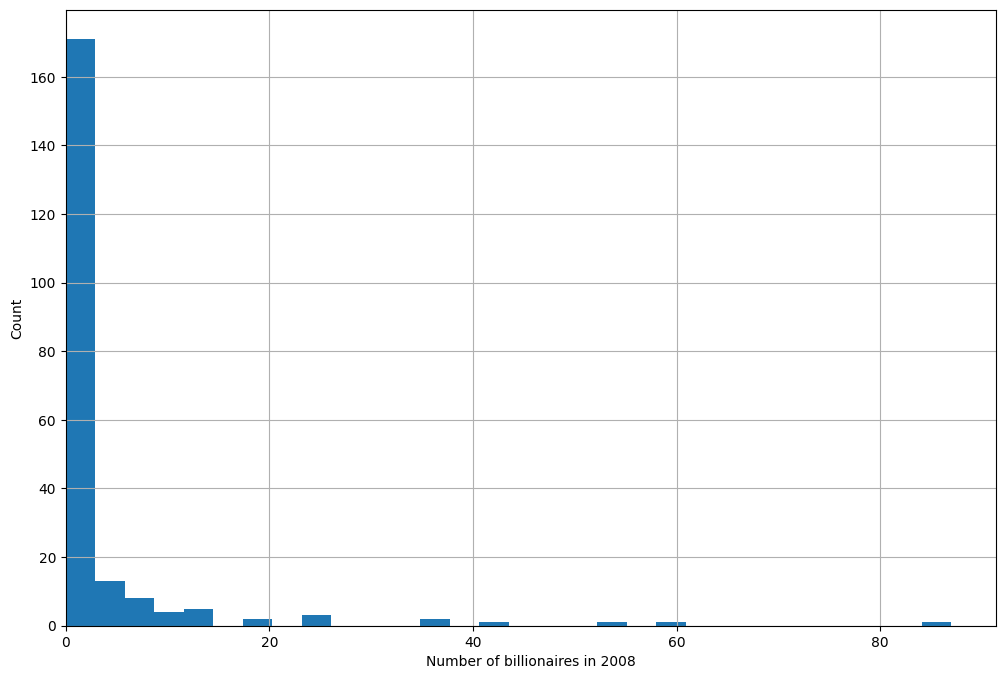

In [123]:
numbil0_2008 = df[
    (df["year"] == 2008) & (df["country"] != "United States")
].loc[:, "numbil0"]

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel("Number of billionaires in 2008")
plt.ylabel("Count")
plt.show()

The distribution of the number of billionaires across countries in 2008 is highly skewed, with most countries having few or none, and a small number having many. This confirms the suitability of Poisson or Negative Binomial regression for such count data.

In Treisman’s paper, the dependent variable — the number of billionaires y_i
 in country i — is modeled as a function of GDP per capita, population size, and years membership in GATT and WTO.In Treisman’s paper, the dependent variable, the number of billionaires y_i in country
 x_i is modeled as a function of GDP per capita, population size, and years membership in GATT and WTO.





In [124]:
# Keep only year 2008
df = df[df["year"] == 2008]

# Add a constant
df["const"] = 1

# Variable sets
reg1 = ["const", "lngdppc", "lnpop", "gattwto08"]
reg2 = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
]
reg3 = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
]

Then we can use the Poisson function from statsmodels to fit the model.

We’ll use robust standard errors as in the author’s paper

In [125]:
# Specify model
poisson_reg = Poisson(df[["numbil0"]], df[reg1], missing="drop").fit(
    cov_type="HC0"
)
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sat, 11 Oct 2025   Pseudo R-squ.:                  0.8574
Time:                        02:01:05   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

GDP per capita and population both have positive and statistically significant effects on the number of billionaires. WTO/GATT membership years is positive but insignificant. The model explains a large portion of the variation (Pseudo R² ≈ 0.86), showing strong predictive power with just these fundamentals.

Our output indicates that GDP per capita, population, and years of membership in the General Agreement on Tariffs and Trade (GATT) are positively related to the number of billionaires a country has, as expected.

Exploring other full featured models

In [126]:
regs = [reg1, reg2, reg3]
reg_names = ["Model 1", "Model 2", "Model 3"]
info_dict = {
    "Pseudo R-squared": lambda x: f"{x.prsquared:.2f}",
    "No. observations": lambda x: f"{int(x.nobs):d}",
}
regressor_order = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
]
results = []

for reg in regs:
    result = Poisson(df[["numbil0"]], df[reg], missing="drop").fit(
        cov_type="HC0", maxiter=100, disp=0
    )
    results.append(result)

results_table = summary_col(
    results=results,
    float_format="%0.3f",
    stars=True,
    model_names=reg_names,
    info_dict=info_dict,
    regressor_order=regressor_order,
)
results_table.add_title(
    "Table 1 - Explaining the Number of Billionaires \
                        in 2008"
)
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw              

GDP per capita and population both have positive and statistically significant effects on the number of billionaires. WTO/GATT membership years is positive but insignificant. The model explains a large portion of the variation (Pseudo R² ≈ 0.86), showing strong predictive power with just these fundamentals.

To analyze our results by country, we can plot the difference between the predicted and actual values, then sort from highest to lowest and plot the first 20

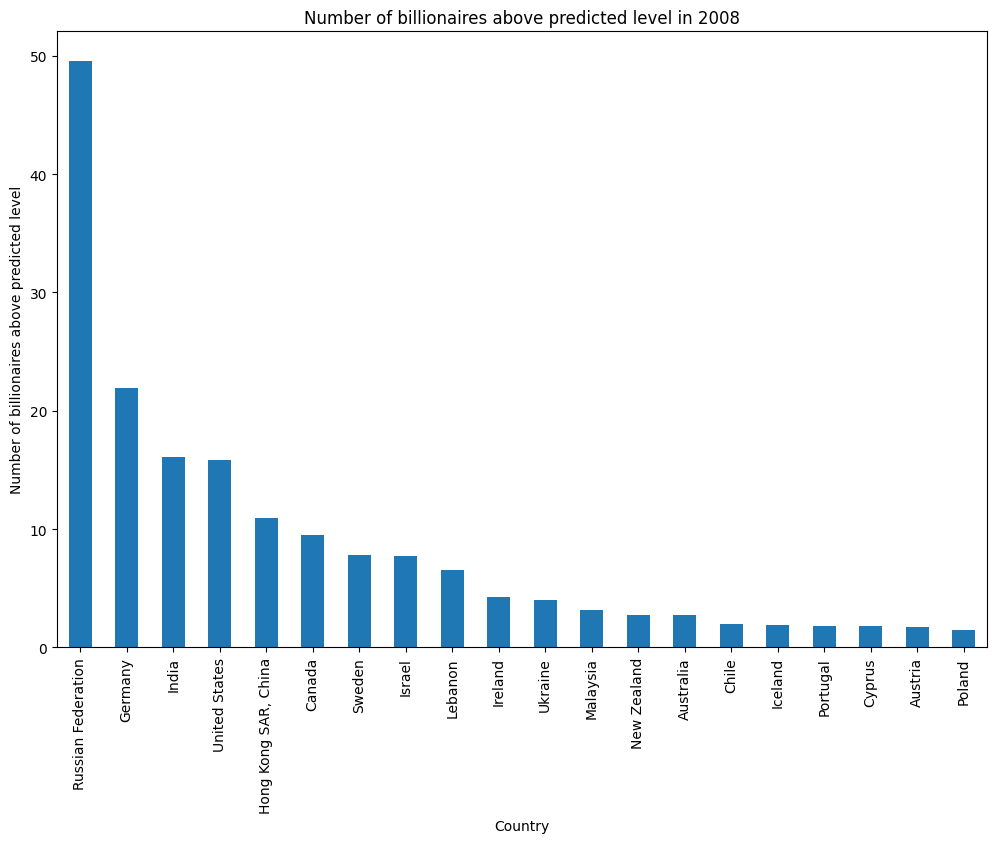

In [127]:
data = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
    "numbil0",
    "country",
]
results_df = df[data].dropna()

# Use last model (model 3)
results_df["prediction"] = results[-1].predict()

# Calculate difference
results_df["difference"] = results_df["numbil0"] - results_df["prediction"]

# Sort in descending order
results_df.sort_values("difference", ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:20].plot(
    "country", "difference", kind="bar", figsize=(12, 8), legend=False
)
plt.ylabel("Number of billionaires above predicted level")
plt.xlabel("Country")
plt.title("Number of billionaires above predicted level in 2008")
plt.show()

, Russia has by far the highest number of billionaires in excess of what is predicted by the model (around 50 more than expected).



Treisman uses this empirical result to discuss possible reasons for Russia’s excess of billionaires, including the origination of wealth in Russia, the political climate, and the history of privatization in the years after the USSR.



Most countries cluster near predicted values, but Russia stands out dramatically with ~50 more billionaires than predicted by fundamentals. This anomaly motivates Treisman’s argument that unique historical and political factors (post-Soviet privatization, oligarchic wealth formation) explain Russia’s billionaire surge.

In [141]:
df = pd.read_csv("fp.csv")
formula = "numbil0 ~ lngdppc + lnpop + lnmcap08 + topint08 + roflaw + nrrents"
pois = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()
# Keep only year 2013
df = df[df["year"] == 2013]


## Does this hold for another year?


In [142]:
 #Add a constant
df["const"] = 1

# Variable sets
reg1 = ["const", "lngdppc", "lnpop", "gattwto08"]
reg2 = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
]
reg3 = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
]

/tmp/ipython-input-1496328969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["const"] = 1


In [143]:
# Specify model
poisson_reg = Poisson(df[["numbil0"]], df[reg1], missing="drop").fit(
    cov_type="HC0"
)
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.387275
         Iterations 8
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  193
Model:                        Poisson   Df Residuals:                      189
Method:                           MLE   Df Model:                            3
Date:                Sat, 11 Oct 2025   Pseudo R-squ.:                  0.8623
Time:                        02:12:56   Log-Likelihood:                -460.74
converged:                       True   LL-Null:                       -3344.9
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.9490      1.558    -16.653      0.000     -29.003     -22.895
lngdppc        0.9907      0.

In [144]:
regs = [reg1, reg2, reg3]
reg_names = ["Model 1", "Model 2", "Model 3"]
info_dict = {
    "Pseudo R-squared": lambda x: f"{x.prsquared:.2f}",
    "No. observations": lambda x: f"{int(x.nobs):d}",
}
regressor_order = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
]
results = []

for reg in regs:
    result = Poisson(df[["numbil0"]], df[reg], missing="drop").fit(
        cov_type="HC0", maxiter=100, disp=0
    )
    results.append(result)

results_table = summary_col(
    results=results,
    float_format="%0.3f",
    stars=True,
    model_names=reg_names,
    info_dict=info_dict,
    regressor_order=regressor_order,
)
results_table.add_title(
    "Table 1 - Explaining the Number of Billionaires \
                        in 2008"
)
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -25.949*** -15.354*** -14.869***
                 (1.558)    (4.173)    (3.346)   
lngdppc          0.991***   0.537***   0.595***  
                 (0.075)    (0.204)    (0.175)   
lnpop            1.053***   0.657***   0.600***  
                 (0.058)    (0.181)    (0.165)   
gattwto08        0.008**    0.003      0.005     
                 (0.004)    (0.003)    (0.004)   
lnmcap08                    0.420***   0.463***  
                            (0.149)    (0.143)   
rintr                       0.001      -0.004    
                            (0.006)    (0.007)   
topint08                    -0.036***  -0.039*** 
                            (0.011)    (0.012)   
nrrents                                -0.015    
                                       (0.012)   
roflaw              

In [146]:
data = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
    "numbil0",
    "country",
]
results_df = df[data].dropna()

# Use last model (model 3)
results_df["prediction"] = results[-1].predict()

# Calculate difference
results_df["difference"] = results_df["numbil0"] - results_df["prediction"]

# Sort in descending order
results_df.sort_values("difference", ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:20].plot(
    "country", "difference", kind="bar", figsize=(12, 8), legend=False
)
plt.ylabel("Number of billionaires above predicted level")
plt.xlabel("Country")
plt.title("Number of billionaires above predicted level in 2013")
plt.show()

In [147]:
# Define Model 3 variable set
reg3 = [
    "const",
    "lngdppc",
    "lnpop",
    "gattwto08",
    "lnmcap08",
    "rintr",
    "topint08",
    "nrrents",
    "roflaw",
]

# Run Poisson regression with robust standard errors
poisson_reg3 = Poisson(df[["numbil0"]], df[reg3], missing="drop").fit(
    cov_type="HC0"
)

# Print summary
print(poisson_reg3.summary())


Optimization terminated successfully.
         Current function value: 2.327852
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  131
Model:                        Poisson   Df Residuals:                      122
Method:                           MLE   Df Model:                            8
Date:                Sat, 11 Oct 2025   Pseudo R-squ.:                  0.8913
Time:                        02:13:30   Log-Likelihood:                -304.95
converged:                       True   LL-Null:                       -2804.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.8693      3.346     -4.444      0.000     -21.427      -8.311
lngdppc        0.5955      0.

In [140]:
# Create table with actual, predicted, and difference
table = results_df[["country", "numbil0", "prediction", "difference"]].head(20)

# Rename columns for clarity
table = table.rename(columns={
    "numbil0": "Actual",
    "prediction": "Predicted",
    "difference": "Difference"
})

# Display as table
print(table.to_string(index=False))


             country  Actual  Predicted  Difference
  Russian Federation    87.0  37.421656   49.578344
             Germany    59.0  37.061602   21.938398
               India    53.0  36.878987   16.121013
       United States   469.0 453.173377   15.826623
Hong Kong SAR, China    26.0  15.087426   10.912574
              Canada    25.0  15.525700    9.474300
              Sweden    10.0   2.217162    7.782838
              Israel     9.0   1.258774    7.741226
             Lebanon     7.0   0.421482    6.578518
             Ireland     6.0   1.723575    4.276425
             Ukraine     7.0   3.004732    3.995268
            Malaysia     8.0   4.861855    3.138145
         New Zealand     4.0   1.241571    2.758429
           Australia    14.0  11.242909    2.757091
               Chile     4.0   2.031185    1.968815
             Iceland     2.0   0.084043    1.915957
            Portugal     4.0   2.154976    1.845024
              Cyprus     2.0   0.190704    1.809296
            